# Add cell features:  samplerID, cellSignificance, cell volume

In [1]:
import uproot as ur
import awkward as ak
import numpy as np

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "7"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:

import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.archs import EFN

from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

from energyflow.utils import data_split

In [4]:
# my worspace and directories
path_prefix = '/home/dportill/LCStudies/'
plotpath = path_prefix+'classifier/Plots_EFN/'
modelpath = path_prefix+'classifier/Models_EFN/'


data_path = '/fast_scratch/atlas_images/v01-45/'

In [5]:
# import graph utilities
import sys
sys.path.append(path_prefix)
from  util import graph_util as gu
from  util import plot_util as pu

## Read dataset trees for pi0 and pipm

Inputs consists of two components:
- `X` : has X_pipm first and then X_pi0. It has shape `(num_clusters,max_num_cells,6)`  The cells are given as `(log(E),eta,phi,samplerID, cellSignificance, cell volume)` values
- `Y` : a numpy array of quark/gluon jet labels (pipm=`1` and pi0=`0`). 

In [6]:
#X = np.load(data_path+'X_4.npy')
X = np.load(path_prefix+'X_added.npy')

In [7]:
Y = tf.keras.utils.to_categorical(np.concatenate((np.ones(90000), np.zeros(90000))))

## Phi_sizes, F_sizes and latent space dimensions

* Phi_sizes : The sizes of the dense layers in the per-particle frontend module $\Phi$. The last element will be the number of latent observables that the model defines. Larger latent space dimensions correspond roughly to higher resolution images.
* F_sizes : The sizes of the dense layers in the backend module $F$.

Default: Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100) 

In [8]:
from energyflow.utils import data_split

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=10000, test=40000)

In [9]:
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)

## PFN with dimension 6 inputs: (log(E),eta,phi,samplerID, cellSignificance, cellVolume)

In [14]:
pfn_6dim = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 6)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    700         input[0][0]                      
__________________________________________________________________________________________________
activation_14 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_14[0][0]              
____________________________________________________________________________________________

In [15]:
# train model
history_6dim = pfn_6dim.fit(X_train, Y_train,
        epochs=100,
        batch_size=500,
        validation_data=(X_val, Y_val),
        verbose=1)

Epoch 1/100
260/260 [==============================] - 21s 64ms/step - loss: 38798144.5939 - acc: 0.4987 - val_loss: 4997005.5000 - val_acc: 0.4975
Epoch 2/100
260/260 [==============================] - 17s 64ms/step - loss: 3172881.5450 - acc: 0.5009 - val_loss: 3193075.5000 - val_acc: 0.4975
Epoch 3/100
260/260 [==============================] - 16s 60ms/step - loss: 2249996.3803 - acc: 0.4968 - val_loss: 1637593.5000 - val_acc: 0.4975
Epoch 4/100
260/260 [==============================] - 14s 55ms/step - loss: 1537249.5551 - acc: 0.5010 - val_loss: 802789.6250 - val_acc: 0.4945
Epoch 5/100
260/260 [==============================] - 14s 55ms/step - loss: 481441.8886 - acc: 0.5012 - val_loss: 225928.7812 - val_acc: 0.5196
Epoch 6/100
260/260 [==============================] - 15s 57ms/step - loss: 282843.3563 - acc: 0.5430 - val_loss: 890844.6875 - val_acc: 0.4975
Epoch 7/100
260/260 [==============================] - 14s 54ms/step - loss: 678905.7114 - acc: 0.5002 - val_loss: 315530.

In [16]:
pfn_6dim.save(modelpath+'pfn_6dim.h5')

In [17]:
# get area under the ROC curve
preds_6dim = pfn_6dim.predict(X_test, batch_size=1000)
auc_6dim = roc_auc_score(Y_test[:,1], preds_6dim[:,1])
print('AUC:', auc_6dim)

### get ROC curve
pfn_fp_6dim, pfn_tp_6dim, threshs_6dim = roc_curve(Y_test[:,1], preds_6dim[:,1])
Rej_6dim=1./pfn_fp_6dim
highEff=pfn_tp_6dim>0.95
pfn_tp_highEff_6dim = pfn_tp_6dim[highEff]
Rej_highEff_6dim=Rej_6dim[highEff]
print("High efficiency AUC:",auc(pfn_tp_highEff_6dim,Rej_highEff_6dim))
print("Rejection at 95% efficiency:", Rej_highEff_6dim[0])

print("at efficiency:", pfn_tp_highEff_6dim[0])
print("AUC:",auc(pfn_tp_6dim,Rej_6dim))

AUC: 0.4955680100161958
High efficiency AUC: 0.022118821116796063
Rejection at 95% efficiency: 1.003574845173959
at efficiency: 0.9779250548136337
AUC: inf


<ipython-input-17-db4b63df363d>:8: RuntimeWarning: divide by zero encountered in true_divide
  Rej_6dim=1./pfn_fp_6dim


<Figure size 799.992x599.976 with 0 Axes>

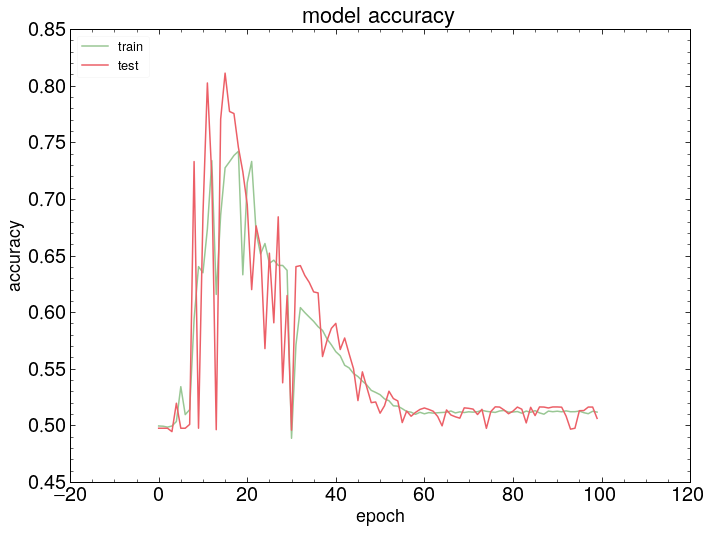

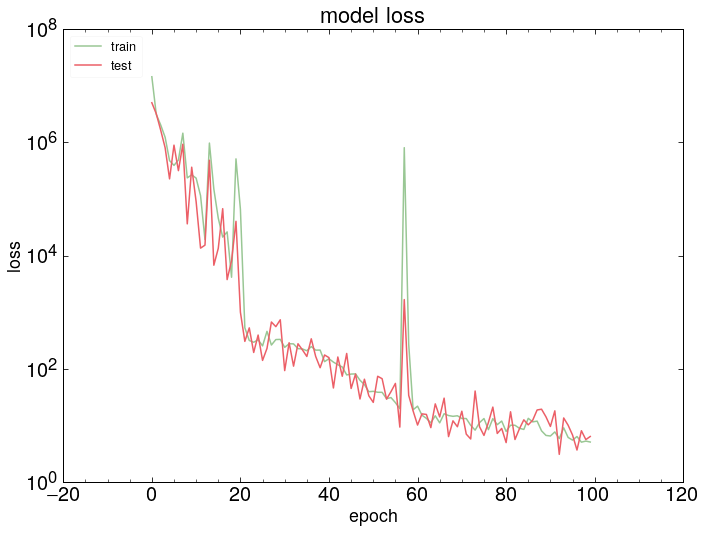

In [18]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_6dim.history['acc'])
plt.plot(history_6dim.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_6dim.history['loss'])
plt.plot(history_6dim.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

<ipython-input-51-bfee9da9f13e>:11: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(pfn_tp_6dim, 1./(pfn_fp_6dim), '-', color='red', label='PFN')


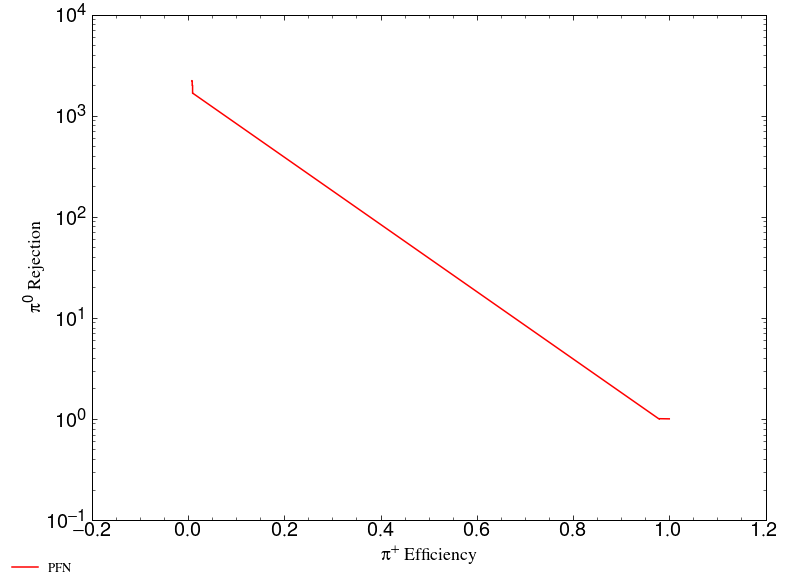

In [51]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

#fig, axes = plt.subplots(1, 1, figsize=(5,5))

fig = plt.figure()

plt.yscale('log')

# plot the ROC curves
plt.plot(pfn_tp_6dim, 1./(pfn_fp_6dim), '-', color='red', label='PFN')

plt.ylabel('$\pi^{0}$ Rejection')
plt.xlabel('$\pi^{+}$ Efficiency')


# axes limits
#axes.set_xlim(0.5, 1)
#axes.set_ylim(-1, 1000)

# make legend and show plot
fig.legend(loc='lower left', frameon=False)

plt.show()


## PFN with dimension 4 inputs: (log(E),eta,phi,samplerID)

In [37]:
# ignore cellSignificance, cellVolume information 
X_4D=X[:,:,:4]

In [40]:
X_4D.shape[-1]

4

In [41]:
pfn_4dim = PFN(input_dim=X_4D.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_21 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_21[0][0]              
____________________________________________________________________________________________

In [42]:
# do train/val/test split 
(X_4D_train, X_4D_val, X_4D_test,
 Y_train, Y_val, Y_test) = data_split(X_4D, Y, val=10000, test=40000)

In [43]:
# train model
history_4dim = pfn_4dim.fit(X_4D_train, Y_train,
        epochs=100,
        batch_size=500,
        validation_data=(X_4D_val, Y_val),
        verbose=1)

Epoch 1/100
260/260 [==============================] - 14s 54ms/step - loss: 8.1474 - acc: 0.6950 - val_loss: 0.7550 - val_acc: 0.7128
Epoch 2/100
260/260 [==============================] - 13s 51ms/step - loss: 0.9268 - acc: 0.7406 - val_loss: 1.0990 - val_acc: 0.7611
Epoch 3/100
260/260 [==============================] - 13s 52ms/step - loss: 0.6473 - acc: 0.7494 - val_loss: 0.5568 - val_acc: 0.7773
Epoch 4/100
260/260 [==============================] - 14s 52ms/step - loss: 0.4820 - acc: 0.7753 - val_loss: 0.4373 - val_acc: 0.7696
Epoch 5/100
260/260 [==============================] - 14s 53ms/step - loss: 0.4575 - acc: 0.7685 - val_loss: 0.4027 - val_acc: 0.7960
Epoch 6/100
260/260 [==============================] - 14s 53ms/step - loss: 0.4239 - acc: 0.7808 - val_loss: 0.4161 - val_acc: 0.7913
Epoch 7/100
260/260 [==============================] - 14s 53ms/step - loss: 0.4354 - acc: 0.7816 - val_loss: 0.3977 - val_acc: 0.7954
Epoch 8/100
260/260 [==============================] - 

In [45]:
pfn_4dim.save(modelpath+'pfn_4dim.h5')

In [48]:
# get area under the ROC curve
preds_4dim = pfn_4dim.predict(X_4D_test, batch_size=1000)
auc_4dim = roc_auc_score(Y_test[:,1], preds_4dim[:,1])
print('AUC:', auc_4dim)

### get ROC curve
pfn_fp_4dim, pfn_tp_4dim, threshs_4dim = roc_curve(Y_test[:,1], preds_4dim[:,1])
Rej_4dim=1./pfn_fp_4dim
highEff=pfn_tp_4dim>0.95
pfn_tp_highEff_4dim = pfn_tp_4dim[highEff]
Rej_highEff_4dim=Rej_4dim[highEff]
print("High efficiency AUC:",auc(pfn_tp_highEff_4dim,Rej_highEff_4dim))
print("Rejection at 95% efficiency:", Rej_highEff_4dim[0])

print("at efficiency:", pfn_tp_highEff_4dim[0])
print("AUC:",auc(pfn_tp_4dim,Rej_4dim))

AUC: 0.9790633959154027
High efficiency AUC: 0.24019260720817737
Rejection at 95% efficiency: 8.896613190730838
at efficiency: 0.9500399281293671
AUC: inf


<ipython-input-48-103b5ea18793>:8: RuntimeWarning: divide by zero encountered in true_divide
  Rej_4dim=1./pfn_fp_4dim


<Figure size 799.992x599.976 with 0 Axes>

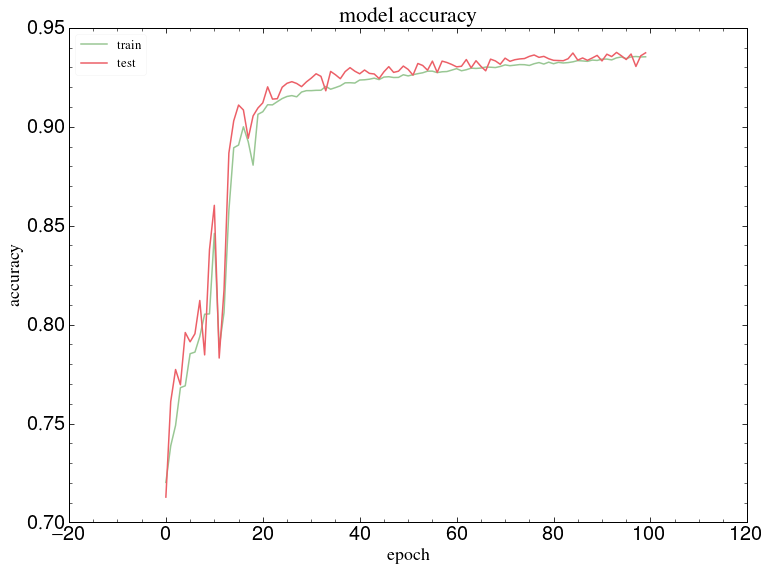

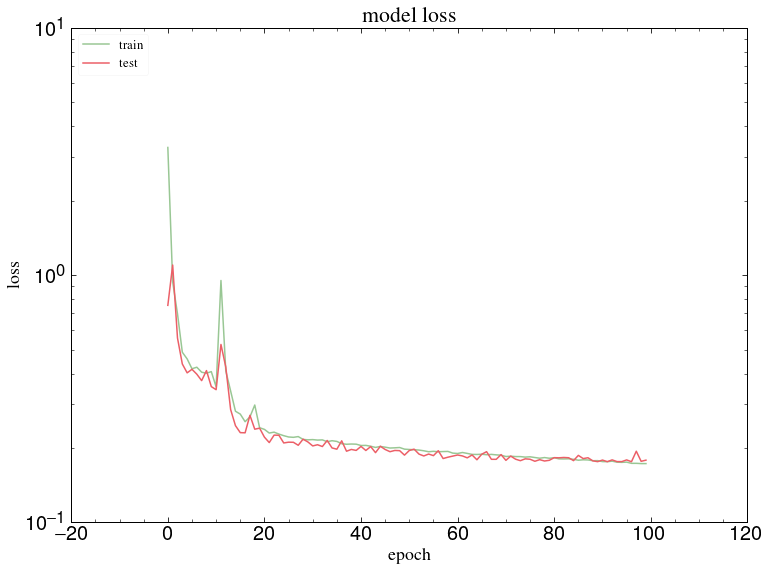

In [49]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_4dim.history['acc'])
plt.plot(history_4dim.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_4dim.history['loss'])
plt.plot(history_4dim.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

<ipython-input-52-1cd3d2829275>:9: RuntimeWarning: divide by zero encountered in true_divide
  axes.plot(pfn_tp_4dim, 1./(pfn_fp_4dim), '-', color='red', label='PFN')
<ipython-input-52-1cd3d2829275>:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes.set_ylim(-1, 1000)


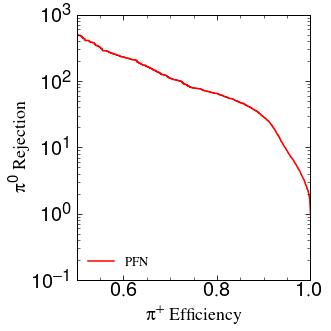

In [52]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

fig, axes = plt.subplots(1, 1, figsize=(5,5))

plt.yscale('log')

# plot the ROC curves
axes.plot(pfn_tp_4dim, 1./(pfn_fp_4dim), '-', color='red', label='PFN')

# axes labels
axes.set_xlabel('$\pi^{+}$ Efficiency')
axes.set_ylabel('$\pi^{0}$ Rejection')

# axes limits
axes.set_xlim(0.5, 1)
axes.set_ylim(-1, 1000)

# make legend and show plot
axes.legend(loc='lower left', frameon=False)

plt.show()

## PFN with dimension 5 inputs: (log(E),eta,phi,samplerID, cellSignificance)

In [21]:
# ignore cellSignificance, cellVolume information 
X_5dim=X[:,:,:5]

In [22]:
X_5dim.shape[-1]

5

In [58]:
pfn_5dim = PFN(input_dim=X_5dim.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    600         input[0][0]                      
__________________________________________________________________________________________________
activation_28 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_28[0][0]              
____________________________________________________________________________________________

In [59]:
# do train/val/test split 
(X_5dim_train, X_5dim_val, X_5dim_test,
 Y_train, Y_val, Y_test) = data_split(X_5dim, Y, val=10000, test=40000)

In [60]:
# train model
history_5dim = pfn_5dim.fit(X_5dim_train, Y_train,
        epochs=100,
        batch_size=500,
        validation_data=(X_5dim_val, Y_val),
        verbose=1)

Epoch 1/100
260/260 [==============================] - 15s 56ms/step - loss: 107.5430 - acc: 0.5756 - val_loss: 1.5866 - val_acc: 0.6655
Epoch 2/100
260/260 [==============================] - 14s 53ms/step - loss: 6.6102 - acc: 0.6646 - val_loss: 1.3067 - val_acc: 0.7497
Epoch 3/100
260/260 [==============================] - 14s 53ms/step - loss: 2.6138 - acc: 0.7182 - val_loss: 0.7596 - val_acc: 0.7893
Epoch 4/100
260/260 [==============================] - 14s 53ms/step - loss: 2.1617 - acc: 0.7151 - val_loss: 2.9114 - val_acc: 0.5644
Epoch 5/100
260/260 [==============================] - 14s 54ms/step - loss: 1.2739 - acc: 0.7277 - val_loss: 0.7128 - val_acc: 0.7150
Epoch 6/100
260/260 [==============================] - 14s 54ms/step - loss: 1.0141 - acc: 0.7462 - val_loss: 1.1637 - val_acc: 0.7802
Epoch 7/100
260/260 [==============================] - 14s 54ms/step - loss: 0.9317 - acc: 0.7490 - val_loss: 0.4611 - val_acc: 0.7797
Epoch 8/100
260/260 [==============================] 

In [61]:
pfn_5dim.save(modelpath+'pfn_5dim.h5')

In [62]:
# get area under the ROC curve
preds_5dim = pfn_5dim.predict(X_5dim_test, batch_size=1000)
auc_5dim = roc_auc_score(Y_test[:,1], preds_5dim[:,1])
print('AUC:', auc_5dim)

### get ROC curve
pfn_fp_5dim, pfn_tp_5dim, threshs_5dim = roc_curve(Y_test[:,1], preds_5dim[:,1])
Rej_5dim=1./pfn_fp_5dim
highEff=pfn_tp_5dim>0.95
pfn_tp_highEff_5dim = pfn_tp_5dim[highEff]
Rej_highEff_5dim=Rej_5dim[highEff]
print("High efficiency AUC:",auc(pfn_tp_highEff_5dim,Rej_highEff_5dim))
print("Rejection at 95% efficiency:", Rej_highEff_5dim[0])

print("at efficiency:", pfn_tp_highEff_5dim[0])
print("AUC:",auc(pfn_tp_5dim,Rej_5dim))


AUC: 0.9741987737627282
High efficiency AUC: 0.20041929535846065
Rejection at 95% efficiency: 6.972869565217391
at efficiency: 0.950032576554904
AUC: inf


<ipython-input-62-90048c455d95>:8: RuntimeWarning: divide by zero encountered in true_divide
  Rej_5dim=1./pfn_fp_5dim


<Figure size 799.992x599.976 with 0 Axes>

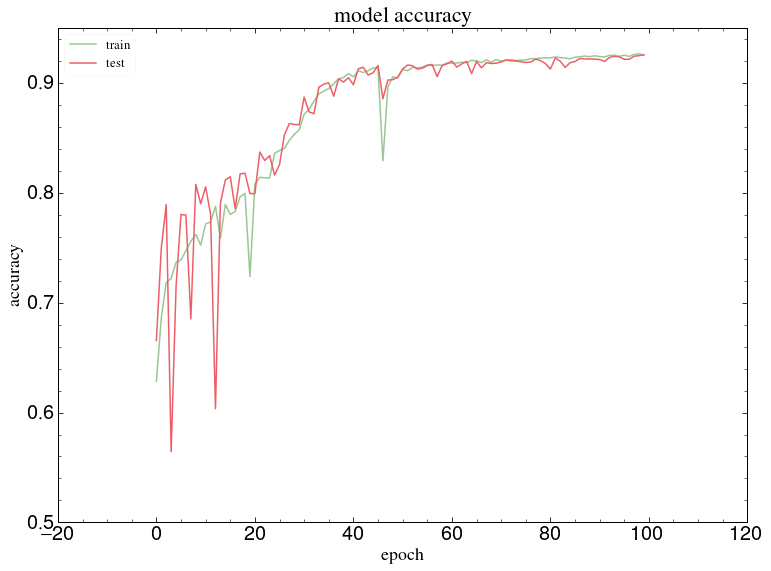

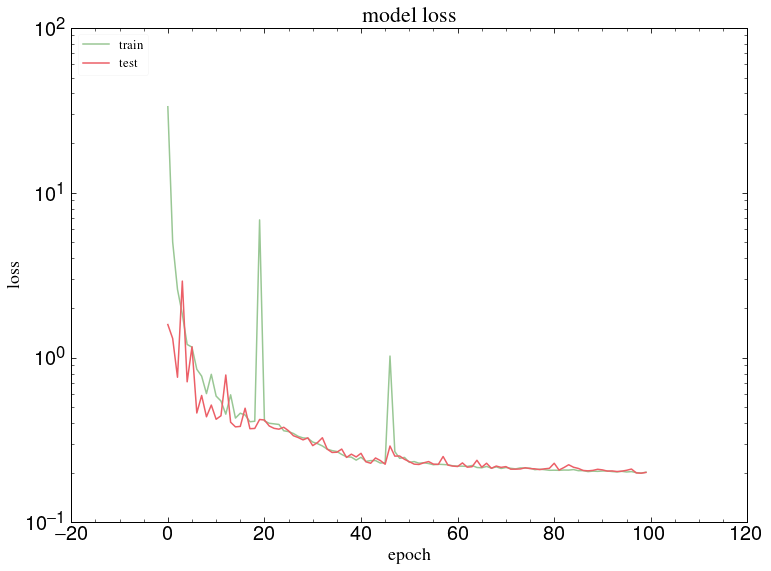

In [63]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_5dim.history['acc'])
plt.plot(history_5dim.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_5dim.history['loss'])
plt.plot(history_5dim.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

<ipython-input-65-415cd752c546>:9: RuntimeWarning: divide by zero encountered in true_divide
  axes.plot(pfn_tp_5dim, 1./(pfn_fp_5dim), '-', color='red', label='PFN')
<ipython-input-65-415cd752c546>:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes.set_ylim(-1, 1000)


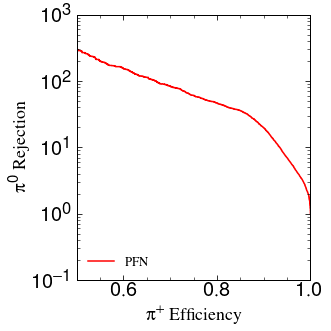

In [65]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

fig, axes = plt.subplots(1, 1, figsize=(5,5))

plt.yscale('log')

# plot the ROC curves
axes.plot(pfn_tp_5dim, 1./(pfn_fp_5dim), '-', color='red', label='PFN')

# axes labels
axes.set_xlabel('$\pi^{+}$ Efficiency')
axes.set_ylabel('$\pi^{0}$ Rejection')

# axes limits
axes.set_xlim(0.5, 1)
axes.set_ylim(-1, 1000)

# make legend and show plot
axes.legend(loc='lower left', frameon=False)

plt.show()

## PFN with dimension 3 inputs: (log(E),eta,phi)

In [66]:
# ignore cellSignificance, cellVolume information 
X_3dim=X[:,:,:3]

In [67]:
X_3dim.shape[-1]

3

In [68]:
pfn_3dim = PFN(input_dim=X_3dim.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    400         input[0][0]                      
__________________________________________________________________________________________________
activation_35 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_35[0][0]              
____________________________________________________________________________________________

In [70]:
# do train/val/test split 
(X_3dim_train, X_3dim_val, X_3dim_test,
 Y_train, Y_val, Y_test) = data_split(X_3dim, Y, val=10000, test=40000)

In [72]:
# train model
history_3dim = pfn_3dim.fit(X_3dim_train, Y_train,
        epochs=100,
        batch_size=500,
        validation_data=(X_3dim_val, Y_val),
        verbose=1)

Epoch 1/100
260/260 [==============================] - 14s 52ms/step - loss: 20.5264 - acc: 0.5435 - val_loss: 0.5647 - val_acc: 0.7364
Epoch 2/100
260/260 [==============================] - 13s 51ms/step - loss: 0.8713 - acc: 0.7186 - val_loss: 0.4783 - val_acc: 0.8080
Epoch 3/100
260/260 [==============================] - 13s 52ms/step - loss: 0.6054 - acc: 0.7569 - val_loss: 0.4674 - val_acc: 0.7990
Epoch 4/100
260/260 [==============================] - 13s 51ms/step - loss: 0.5242 - acc: 0.7766 - val_loss: 0.4559 - val_acc: 0.7948
Epoch 5/100
260/260 [==============================] - 13s 51ms/step - loss: 0.5191 - acc: 0.7773 - val_loss: 0.5113 - val_acc: 0.7512
Epoch 6/100
260/260 [==============================] - 14s 52ms/step - loss: 0.4906 - acc: 0.7772 - val_loss: 0.4460 - val_acc: 0.7951
Epoch 7/100
260/260 [==============================] - 14s 52ms/step - loss: 0.4622 - acc: 0.7864 - val_loss: 0.6002 - val_acc: 0.7679
Epoch 8/100
260/260 [==============================] -

In [73]:
pfn_3dim.save(modelpath+'pfn_3dim.h5')

In [74]:

# get area under the ROC curve
preds_3dim = pfn_3dim.predict(X_3dim_test, batch_size=1000)
auc_3dim = roc_auc_score(Y_test[:,1], preds_3dim[:,1])
print('AUC:', auc_3dim)

### get ROC curve
pfn_fp_3dim, pfn_tp_3dim, threshs_3dim = roc_curve(Y_test[:,1], preds_3dim[:,1])
Rej_3dim=1./pfn_fp_3dim
highEff=pfn_tp_3dim>0.95
pfn_tp_highEff_3dim = pfn_tp_3dim[highEff]
Rej_highEff_3dim=Rej_3dim[highEff]
print("High efficiency AUC:",auc(pfn_tp_highEff_3dim,Rej_highEff_3dim))
print("Rejection at 95% efficiency:", Rej_highEff_3dim[0])

print("at efficiency:", pfn_tp_highEff_3dim[0])
print("AUC:",auc(pfn_tp_3dim,Rej_3dim))


AUC: 0.9706728319351656
High efficiency AUC: 0.18387001318055415
Rejection at 95% efficiency: 5.900946185688942
at efficiency: 0.9500074839095943
AUC: inf


<ipython-input-74-fb24a46c3d86>:8: RuntimeWarning: divide by zero encountered in true_divide
  Rej_3dim=1./pfn_fp_3dim


<Figure size 799.992x599.976 with 0 Axes>

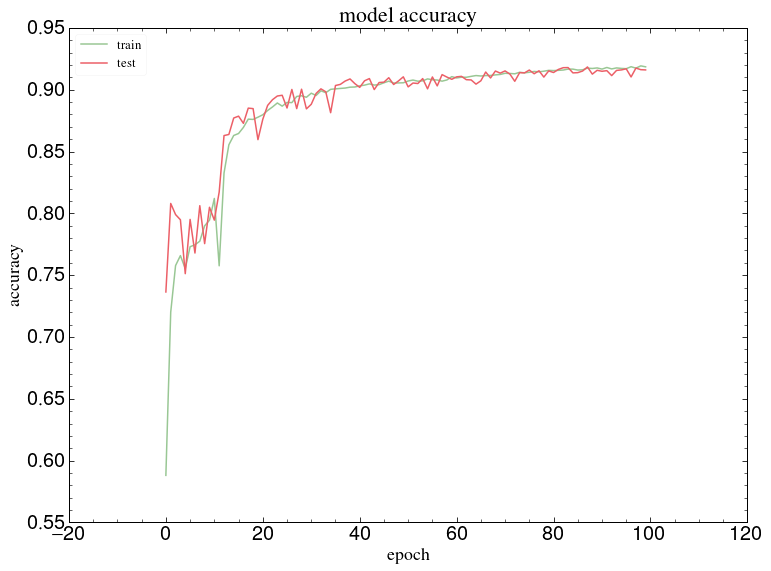

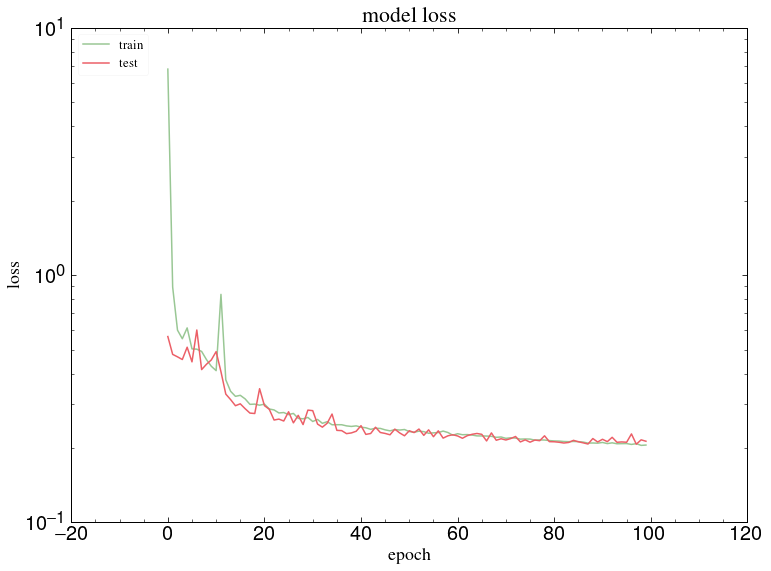

In [75]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_3dim.history['acc'])
plt.plot(history_3dim.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Plots/accuracy_' + layer + '.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_3dim.history['loss'])
plt.plot(history_3dim.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig(plotpath + 'loss_' + layer + '.pdf')
plt.show()

<ipython-input-76-3d7132f8717f>:9: RuntimeWarning: divide by zero encountered in true_divide
  axes.plot(pfn_tp_3dim, 1./(pfn_fp_3dim), '-', color='red', label='PFN')
<ipython-input-76-3d7132f8717f>:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes.set_ylim(-1, 1000)


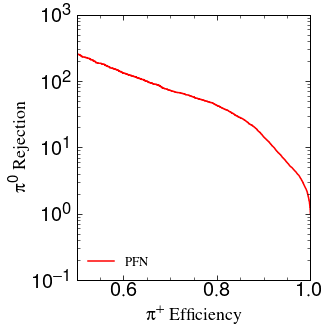

In [76]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

fig, axes = plt.subplots(1, 1, figsize=(5,5))

plt.yscale('log')

# plot the ROC curves
axes.plot(pfn_tp_3dim, 1./(pfn_fp_3dim), '-', color='red', label='PFN')

# axes labels
axes.set_xlabel('$\pi^{+}$ Efficiency')
axes.set_ylabel('$\pi^{0}$ Rejection')

# axes limits
axes.set_xlim(0.5, 1)
axes.set_ylim(-1, 1000)

# make legend and show plot
axes.legend(loc='lower left', frameon=False)

plt.show()

<ipython-input-79-fb9e6022fed4>:12: RuntimeWarning: divide by zero encountered in true_divide
  axes.plot(pfn_tp_3dim, 1./(pfn_fp_3dim), '-', color='red', label='3D')
<ipython-input-79-fb9e6022fed4>:13: RuntimeWarning: divide by zero encountered in true_divide
  axes.plot(pfn_tp_4dim, 1./(pfn_fp_4dim), '-', color='blue', label='3D+samplerID')
<ipython-input-79-fb9e6022fed4>:14: RuntimeWarning: divide by zero encountered in true_divide
  axes.plot(pfn_tp_5dim, 1./(pfn_fp_5dim), '-', color='black', label='3D+samplerID+Noise')
<ipython-input-79-fb9e6022fed4>:15: RuntimeWarning: divide by zero encountered in true_divide
  axes.plot(pfn_tp_6dim, 1./(pfn_fp_6dim), '-', color='orange', label='3D+samplerID+Noise+Volume')
<ipython-input-79-fb9e6022fed4>:24: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes.set_ylim(-1, 1000)


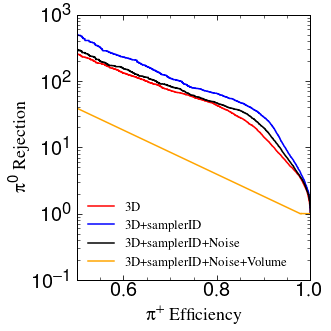

In [79]:
# some nicer plot settings 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

fig, axes = plt.subplots(1, 1, figsize=(5,5))

######################### ROC Curve Plot #########################

plt.yscale('log')

# plot the ROC curves
axes.plot(pfn_tp_3dim, 1./(pfn_fp_3dim), '-', color='red', label='3D')
axes.plot(pfn_tp_4dim, 1./(pfn_fp_4dim), '-', color='blue', label='3D+samplerID')
axes.plot(pfn_tp_5dim, 1./(pfn_fp_5dim), '-', color='black', label='3D+samplerID+Noise')
axes.plot(pfn_tp_6dim, 1./(pfn_fp_6dim), '-', color='orange', label='3D+samplerID+Noise+Volume')
#axes.plot(pfn_tp_l200, 1./(pfn_fp_l200), '-', color='green', label='l=200')

# axes labels
axes.set_xlabel('$\pi^{+}$ Efficiency')
axes.set_ylabel('$\pi^{0}$ Rejection')

# axes limits
axes.set_xlim(0.5, 1)
axes.set_ylim(-1, 1000)

# make legend and show plot
axes.legend(loc='lower left', frameon=False)

plt.show()

## Plot the features

- `X` : has X_pipm first and then X_pi0. It has shape `(num_clusters,max_num_cells,6)`  The cells are given as `(log(E),eta,phi, cell_geo_sampling, cell_geo_sigma , cell_geo_volume)` values

X[cluster, cell, feature]

max(X)[180000,2000,6]

In [105]:
Xflat_logE=ak.flatten(X[:,:,0])

In [107]:
Xflat_eta=ak.flatten(X[:,:,1])

In [109]:
Xflat_phi=ak.flatten(X[:,:,2])

In [110]:
Xflat_sampling=ak.flatten(X[:,:,3])

In [112]:
Xflat_sigma=ak.flatten(X[:,:,4])

In [115]:
Xflat_volume=ak.flatten(X[:,:,5])

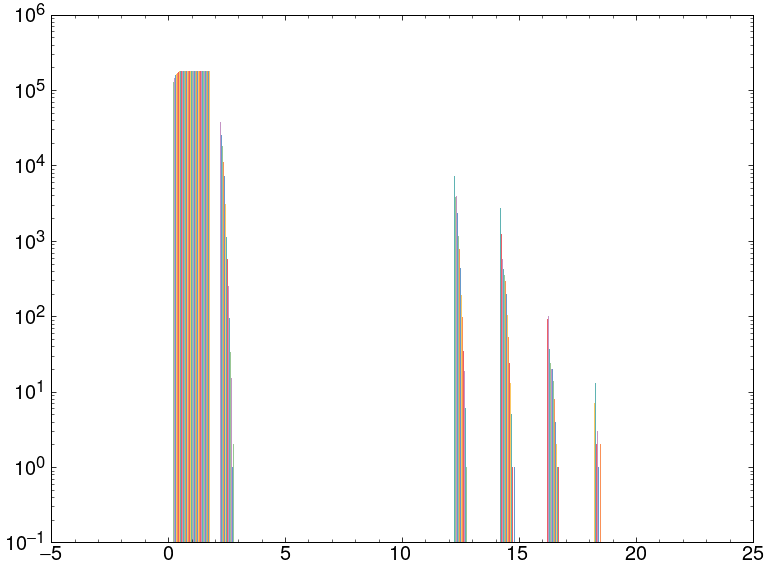

In [141]:
fig = plt.figure()
plt.hist(X[:,:,3]*10.)
plt.yscale('log')
plt.show()

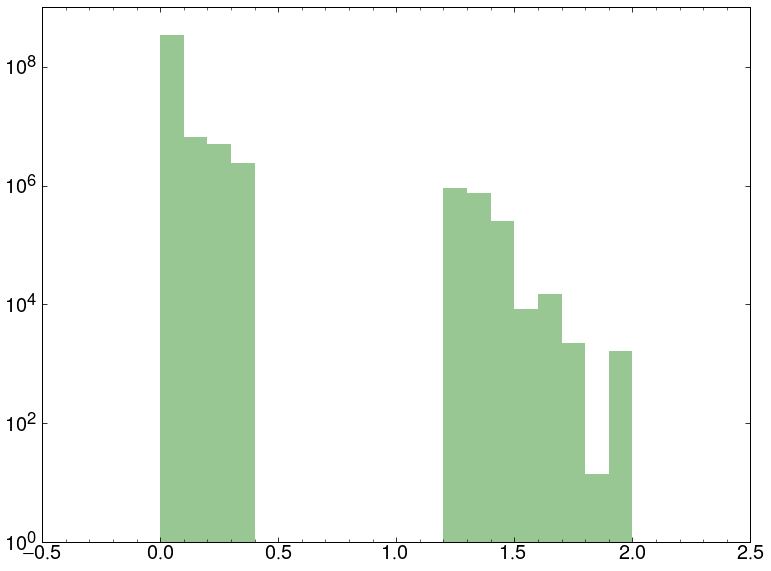

In [142]:
fig = plt.figure()
plt.hist(ak.flatten(X[:,:,3]),bins = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0])
plt.yscale('log')
plt.show()

# sigma

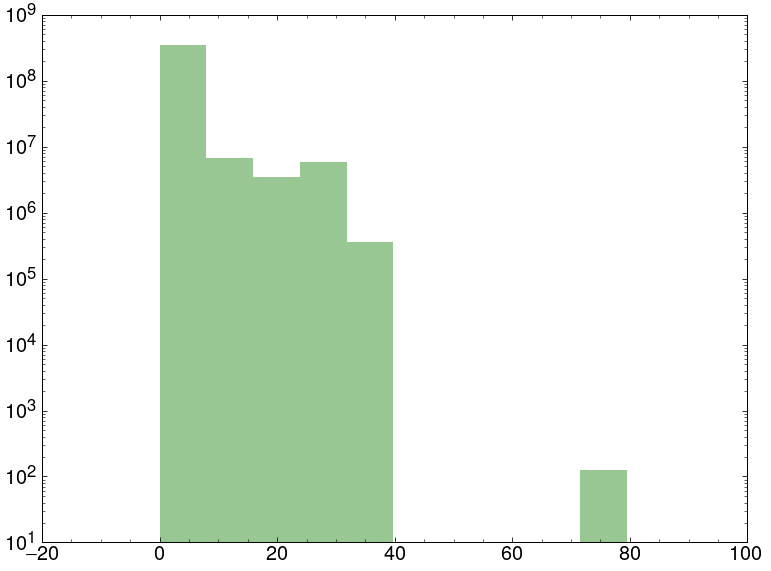

In [144]:
fig = plt.figure()
plt.hist(ak.flatten(X[:,:,4]))
plt.yscale('log')
plt.show()

# Volume

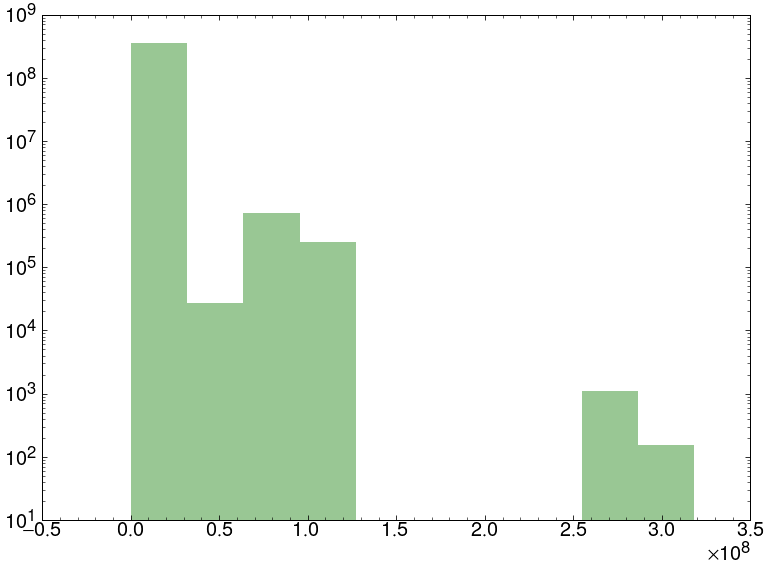

In [145]:
fig = plt.figure()
plt.hist(ak.flatten(X[:,:,5]))
plt.yscale('log')
plt.show()

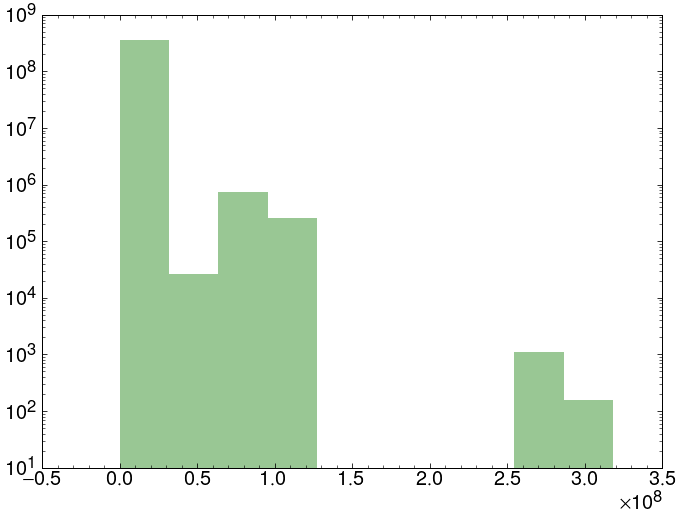

In [8]:
fig = plt.figure()
plt.hist(ak.flatten(X[:,:,5]))
plt.yscale('log')
plt.show()

## PFN with dimension 5 inputs: (log(E),eta,phi,samplerID, cellSignificance)

In [24]:
# ignore cellSignificance, cellVolume information 
X_5dim=X[:,:,:5]

In [25]:
X_5dim.shape[-1]

5

In [16]:
X_5dim_norm=X_5dim[:,:,4]*0.01

In [20]:
X_5dim_norm[:,:,4]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

## Reescaling the cell features

(log(E),eta,phi,samplerID, cellSignificance, cellVolume)

In [32]:
X[0]

array([[ 4.53063501e+00,  4.29472327e-03, -1.81615353e-03,
         2.00000000e-01,  2.73519077e+01,  6.52059000e+05],
       [ 1.74413206e+00,  4.29523364e-03, -2.63937712e-02,
         2.00000000e-01,  2.73519077e+01,  6.52059000e+05],
       [ 3.16158280e+00,  4.29426134e-03,  2.27617025e-02,
         2.00000000e-01,  2.73519077e+01,  6.52059000e+05],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [27]:
X_test = X[:,:,4]*0.01

In [31]:
X_test[0]

array([0.27351908, 0.27351908, 0.27351908, ..., 0.        , 0.        ,
       0.        ])

In [41]:
X[0,0]

array([ 4.53063501e+00,  4.29472327e-03, -1.81615353e-03,  2.00000000e-01,
        2.73519077e+01,  6.52059000e+05])

In [48]:
X_test = X[0,0,4]*0.01

In [49]:
X_test

0.27351907730102537

In [50]:
X_scale=np.ones(X.shape,dtype=np.float64);

In [52]:
X_scale

array([[[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]],

       [[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]],

       [[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]],

       ...,

       [[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]],

       [[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        .